To run this, press "*Runtime*" and press "*Run all*" on a **free** Tesla T4 Google Colab instance!
<div class="align-center">
  <a href="https://github.com/unslothai/unsloth"><img src="https://github.com/unslothai/unsloth/raw/main/images/unsloth%20new%20logo.png" width="115"></a>
  <a href="https://discord.gg/u54VK8m8tk"><img src="https://github.com/unslothai/unsloth/raw/main/images/Discord button.png" width="145"></a>
  <a href="https://ko-fi.com/unsloth"><img src="https://github.com/unslothai/unsloth/raw/main/images/Kofi button.png" width="145"></a></a> Join Discord if you need help + ⭐ <i>Star us on <a href="https://github.com/unslothai/unsloth">Github</a> </i> ⭐
</div>

To install Unsloth on your own computer, follow the installation instructions on our Github page [here](https://github.com/unslothai/unsloth#installation-instructions---conda).

You will learn how to do [data prep](#Data), how to [train](#Train), how to [run the model](#Inference), & [how to save it](#Save) (eg for Llama.cpp).

**[NEW] Llama-3 8b is trained on a crazy 15 trillion tokens! Llama-2 was 2 trillion.**

In [ ]:
%%capture
# Installs Unsloth, Xformers (Flash Attention) and all other packages!
!pip install "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"
# !pip install --no-deps "xformers<0.0.26" trl peft accelerate bitsandbytes
!pip install trl peft accelerate bitsandbytes
!pip install xformers

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


* We support Llama, Mistral, CodeLlama, TinyLlama, Vicuna, Open Hermes etc
* And Yi, Qwen ([llamafied](https://huggingface.co/models?sort=trending&search=qwen+llama)), Deepseek, all Llama, Mistral derived archs.
* We support 16bit LoRA or 4bit QLoRA. Both 2x faster.
* `max_seq_length` can be set to anything, since we do automatic RoPE Scaling via [kaiokendev's](https://kaiokendev.github.io/til) method.
* [**NEW**] With [PR 26037](https://github.com/huggingface/transformers/pull/26037), we support downloading 4bit models **4x faster**! [Our repo](https://huggingface.co/unsloth) has Llama, Mistral 4bit models.

In [ ]:
from unsloth import FastLanguageModel
from datasets import load_dataset, Dataset
from pydantic import BaseModel, ValidationError, Field
from sklearn.model_selection import StratifiedKFold
import pandas as pd
import numpy as np
import torch
import os
from typing import Literal
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, f1_score, accuracy_score
from collections import defaultdict
from trl import SFTTrainer
from transformers import TrainingArguments

max_seq_length = 2048 # Choose any! We auto support RoPE Scaling internally!
dtype = torch.bfloat16 # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = True # Use 4bit quantization to reduce memory usage. Can be False.

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


In [ ]:
# 4bit pre quantized models we support for 4x faster downloading + no OOMs.
fourbit_models = [
    "unsloth/mistral-7b-bnb-4bit",
    "unsloth/mistral-7b-instruct-v0.2-bnb-4bit",
    "unsloth/llama-2-7b-bnb-4bit",
    "unsloth/gemma-7b-bnb-4bit",
    "unsloth/gemma-7b-it-bnb-4bit", # Instruct version of Gemma 7b
    "unsloth/gemma-2b-bnb-4bit",
    "unsloth/gemma-2b-it-bnb-4bit", # Instruct version of Gemma 2b
    "unsloth/llama-3-8b-bnb-4bit",
    "unsloth/Phi-3-mini-4k-instruct" # [NEW] 15 Trillion token Llama-3
] # More models at https://huggingface.co/unsloth

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/mistral-7b-bnb-4bit",
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
    # token = "hf_...", # use one if using gated models like meta-llama/Llama-2-7b-hf
)

model = FastLanguageModel.get_peft_model(
      model,
      r = 16, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
      target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
      lora_alpha = 16,
      lora_dropout = 0, # Supports any, but = 0 is optimized
      bias = "none",    # Supports any, but = "none" is optimized
      # [NEW] "unsloth" uses 30% less VRAM, fits 2x larger batch sizes!
      use_gradient_checkpointing = "unsloth", # True or "unsloth" for very long context
      random_state = 777,
      use_rslora = False,  # We support rank stabilized LoRA
      loftq_config = None, # And LoftQ
    )

==((====))==  Unsloth: Fast Mistral patching release 2024.5
   \\   /|    GPU: NVIDIA A100-SXM4-40GB. Max memory: 39.564 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.3.0+cu121. CUDA = 8.0. CUDA Toolkit = 12.1.
\        /    Bfloat16 = TRUE. Xformers = 0.0.26.post1. FA = False.
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth


Unsloth 2024.5 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


In [ ]:
def generate_text(prompt):
  """
  Generate text for LLM based on input prompt
  :param prompt: input prompt
  :param max_length:
  :type prompt: str
  :type max_length: int
  """
    # Tokenize the prompt
  inputs = tokenizer(prompt, return_tensors="pt").input_ids.to("cuda")
  outputs = model.generate(inputs,
                           max_new_tokens=10,
                           pad_token_id=tokenizer.eos_token_id,
                           #temperature=0.001
                           ) # set temperature here?
    # Decode the response
  response = tokenizer.decode(outputs[0], skip_special_tokens=True)

  return response

def clean_output(output, eos_token, output_only=False):
  """
  This function specifically cleans up the output given by Llama 2 chat,
  to remove the prompt, make sure it is in the correct format, and remove any empty lines.
  :param output: model generated output
  :param labels: all possible classes in TOEFL/ICLE
  :param eos_token: end-of-sequence token to split model output on
  :param output_only, default False: if True, extract only the newly generated output by model and remove the prompt. mostly used for debugging
  :type output: str
  :type labels: list
  :type eos_token: str
  """
  pure_output = output.split(eos_token)
  pure_output = pure_output[-1]
  pure_output = pure_output.strip()
  final_output = pure_output
  if output_only==False: # whether to extract only json-formatted string in the output or not
    predicted_classes=0
    language_class_dict = {'arabic': 'ARA',
                            'bulgarian': 'BUL',
                             'chinese': 'CHI',
                             'czech': 'CZE',
                             "french": "FRE",
                             "german": "GER",
                             "hindi": "HIN",
                             "italian": "ITA",
                             "japanese": "JPN",
                             "korean": 'KOR',
                             "spanish": "SPA",
                             "telugu": "TEL",
                             "turkish": "TUR",
                             "russian": "RUS",
                             "english": "ENG",
                            'sp': 'SPA'
                             }
    # if '}' in final_output:
    #   x = output.split("}")
    #   for piece in x:
    #     if 'native_lang' in piece:
    #       x = piece.split(":")
    #       label = x[-1]
    #       label = label.strip()
    #       label = label.replace('"', '')
    #       label = label.replace('\n', '')
    #       final_output = '{"native_lang":"' + label + '"}'
    # if 'Class:' in final_output:
    #   x = output.split("Class:")
    #   label = x[-1]
    #   label = label.strip()
    #   label = label.replace('"', '')
    #   label = label.replace('\n', '')
    #   label = label.replace('.', '')
    #   final_output = label
    for lang, label in language_class_dict.items():
      if lang in final_output.lower() or label in final_output:
        predicted_classes+=1 # check if it predicts more than one class
        # if predicted_classes>1:
        #   final_output = '{"native_lang":"undefined"}'
        #   break
        # else:
        final_output = '{"native_lang":"' + label + '"}'
  return final_output

prompt_retry_eng = '''
  You previously mistakenly predicted this text as "ENG" (English). The class is NOT English.
  Please classify the native language of the author of the text again.
  '''

def classify(texts, goldlabels, dataset, filter_token, results_filepath, closedopen_setting="closed", openai_api=False):
  '''
  :param texts: list of texts
  :param goldlabels: list of gold labels
  :param dataset: TOEFL or ICLE
  :param sos_token: start-of-sequence token
  :param sys_token: start of system prompt token
  :param sys_end_token: end of system prompt token
  :param eos_token: end-of-sequence token
  :param filter_token: token to get cleaned output
  :type texts: list
  :type goldlabels: list
  :type dataset: str
  :returns predictions: a list of model predictions
  '''
  predictions = []
  if dataset == "ICLE":
    sys_prompt = prompt_ICLE
    prompt_retry = prompt_retry_ICLE
    all_labels = all_labels_ICLE
    NLI_prediction = NLI_prediction_ICLE
    main_task_prompt = main_task_prompt_ICLE
  count = 1
  if closedopen_setting == 'open':
    main_task_prompt = ''
    sys_prompt = prompt_open
    NLI_prediction = NLI_prediction_open
  for text, gold in zip(texts, goldlabels):
    promptcounter = 0
    # main_task = text + '\n\n' + main_task_prompt
    # messages = [
        # {'role': "system", "content": sys_prompt},
        # {'role': "user", "content": main_task}]
    # messages = [{'role': "user", "content": sys_prompt + "\n" +main_task}]
    while True:
      try:
        if openai_api==True:
          response = client.chat.completions.create(
              model=model,
              messages=messages,
              seed=7,
              temperature=0.7)
          output_only = response.choices[0].message.content
        else:
          # fullprompt = "Question: " + sys_prompt + '\n\n' + text + "\nAnswer:" #flant5 open
          #fullprompt = "Context: " + sys_prompt + text + '\nQuestion: '+ main_task_prompt + "\nAnswer:"
          fullprompt = "Instruction: " + sys_prompt + '\n\n' + main_task_prompt + '\n\nInput: '+ text + "\nResponse:"
          #fullprompt = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
          output = generate_text(fullprompt) # generate text per TOEFL text
          output_only = clean_output(output, filter_token, output_only=True)
          #print(fullprompt)
          print(output_only)
          final_output = clean_output(output, filter_token)
        #print(final_output)
        # print(final_output)
        validated_response = NLI_prediction.model_validate_json(final_output) # use class to validate json string
        response_dict = validated_response.model_dump() # dump validated response into dict
        predicted_native_lang = response_dict['native_lang'] # get the predicted native language
        if predicted_native_lang == "ENG" and closedopen_setting=="closed": # reiterate prompt if model predicts english
          # print(final_output)
          fullprompt = "Instruction: " + sys_prompt + '\n\n' + main_task_prompt + '\n' + prompt_retry_eng + '\n\nInput: '+ text + "\nResponse:"
          # messages.append({'role': 'assistant', 'content': output_only})
          # messages.append({'role': "user", "content": prompt_retry_eng})
          # fullprompt = "Context: " + sys_prompt + text + '\nQuestion: '+ main_task_prompt + prompt_retry_eng + "\nAnswer:"
          promptcounter+=1
          if promptcounter > 4: # try 5 times to reprompt, if still unable to extract predicted label, append other
            response_dict = {'native_lang': 'other'}
            predictions.append('other')
            break
        else:
          predictions.append(predicted_native_lang) # append it to list of predictions
          break
      # print(final_output)
      except ValidationError as e: # if there is a validation error, make model retry
        # messages.append({'role': 'assistant', 'content': output_only})
        # messages.append({'role': "user", "content": prompt_retry})
        # fullprompt = "Context: " + sys_prompt + text + '\nQuestion: '+ main_task_prompt + prompt_retry + "\nAnswer:"
        fullprompt = "Instruction: " + sys_prompt + '\n\n' + main_task_prompt + '\n' + prompt_retry + '\n\nInput: '+ text + "\nResponse:"
        # fullprompt = sos_token + sys_token + sys_prompt + sys_end_token + '\n\n' + text + main_task_prompt + prompt_retry + eos_token
        # fullprompt = output + prompt_retry + eos_token
        promptcounter +=1
        if promptcounter > 4: # try 5 times to reprompt, if still unable to extract predicted label, append other
          response_dict = {'native_lang': 'other'}
          predictions.append('other')
          break
    print(count, response_dict)
    print('F1 score:', "{:.2f}".format(f1_score(goldlabels[0:count], predictions, average="macro")))
    count +=1
  return predictions

In [ ]:
class NLI_prediction_ICLE(BaseModel):
  native_lang: Literal['BUL', 'CHI', 'CZE', 'FRE', 'JPN', 'RUS', 'SPA']

all_labels_ICLE = ['BUL', 'CHI', 'CZE', 'FRE', 'JPN', 'RUS', 'SPA']

prompt_ICLE = '''
  You are a forensic linguistics expert that reads English texts written by non-native authors to classify the native language of the author as one of:
  "BUL": Bulgarian
  "CHI": Chinese
  "CZE": Czech
  "FRE": French
  "JPN": Japanese
  "RUS": Russian
  "SPA": Spanish
  Use clues such as spelling errors, word choice, syntactic patterns, and grammatical errors to decide on the native language of the author.\n\n

  DO NOT USE ANY OTHER CLASS.
  IMPORTANT: Do not classify any input as "ENG" (English). English is an invalid choice.

  Valid output formats:
  Class: "BUL"
  Class: "CHI"
  Class: "CZE"
  Class: "SPA"

  You ONLY respond in JSON files.
  The expected output from you has to be:"json {"native_lang": The chosen class, BUL, CHI, CZE, FRE, JPN, RUS, or SPA}"
  '''

main_task_prompt_ICLE = '''Classify the text above as one of BUL, CHI, CZE, FRE, JPN, RUS, or SPA. Do not output any other class - do NOT choose "ENG" (English). What is the closest native language of the author of this English text from the given list?'''

prompt_retry_ICLE = '''
  Your classification is not in the list of possible languages.
  Please try again and choose only one of the following classes:
  BUL, CHI, CZE, FRE, JPN, RUS, or SPA
  '''

In [ ]:
icle = "/content/drive/MyDrive/thesis_NLI/ICLE-NLI-results.csv"

alpaca_prompt = '''
### Instruction:
You are a forensic linguistics expert that reads English texts written by non-native authors to classify the native language of the author as one of:
"BUL": Bulgarian
"CHI": Chinese
"CZE": Czech
"FRE": French
"JPN": Japanese
"RUS": Russian
"SPA": Spanish
Use clues such as spelling errors, word choice, syntactic patterns, and grammatical errors to decide on the native language of the author.\n\n

DO NOT USE ANY OTHER CLASS.
IMPORTANT: Do not classify any input as "ENG" (English). English is an invalid choice.

Valid output formats:
Class: "BUL"
Class: "CHI"
Class: "CZE"
Class: "SPA"

Classify the text below as one of BUL, CHI, CZE, FRE, JPN, RUS, or SPA. Do not output any other class - do NOT choose "ENG" (English). What is the closest native language of the author of this English text from the given list?

### Input:
{}

### Response:
{}'''

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
df_icle = pd.read_csv(icle)
x = df_icle['text'].tolist()
y = df_icle['language'].tolist()

In [ ]:
EOS_TOKEN = tokenizer.eos_token # Must add EOS_TOKEN
def formatting_prompts_func(examples):
    inputs       = examples["text"]
    outputs      = examples["language"]
    texts = []
    for input, output in zip(inputs, outputs):
        # Must add EOS_TOKEN, otherwise your generation will go on forever!
        text = alpaca_prompt.format(input, output) + EOS_TOKEN
        texts.append(text)
    return { "text" : texts, }
pass

In [7]:
for ind, rs in zip(range(0,2), [3407, 777]):
  count=0
  accuracies=[]
  all_predictions = []
  all_test_index = []
  for train_index, test_index in skf.split(x, y):
    model, tokenizer = FastLanguageModel.from_pretrained(
        model_name = "unsloth/mistral-7b-bnb-4bit",
        max_seq_length = max_seq_length,
        dtype = dtype,
        load_in_4bit = load_in_4bit,
      # token = "hf_...", # use one if using gated models like meta-llama/Llama-2-7b-hf)
      )
    model = FastLanguageModel.get_peft_model(
        model,
        r = 16, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
        target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
        lora_alpha = 16,
        lora_dropout = 0, # Supports any, but = 0 is optimized
        bias = "none",    # Supports any, but = "none" is optimized
        # [NEW] "unsloth" uses 30% less VRAM, fits 2x larger batch sizes!
        use_gradient_checkpointing = "unsloth", # True or "unsloth" for very long context
        random_state = rs,
        use_rslora = False,  # We support rank stabilized LoRA
        loftq_config = None, # And LoftQ
      )
    x_train_fold, x_test_fold = np.array(x)[train_index], np.array(x)[test_index]
    y_train_fold, y_test_fold = np.array(y)[train_index], np.array(y)[test_index]
    train_dict = {'text': x_train_fold, 'language': y_train_fold}
    dataset = Dataset.from_dict(train_dict)
    dataset = dataset.map(formatting_prompts_func, batched = True,)
    trainer = SFTTrainer(
      model = model,
      tokenizer = tokenizer,
      train_dataset = dataset,
      dataset_text_field = "text",
      max_seq_length = max_seq_length,
      dataset_num_proc = 2,
      packing = False, # Can make training 5x faster for short sequences.
      args = TrainingArguments(
          per_device_train_batch_size = 4, # The batch size per GPU/TPU core/CPU for training. Zhang et al set this to 4
          gradient_accumulation_steps = 4,
          warmup_steps = 5,
          #max_steps = 0,
          num_train_epochs=3,
          learning_rate = 1e-4, # originally 2e-4
          fp16 = not torch.cuda.is_bf16_supported(),
          bf16 = torch.cuda.is_bf16_supported(),
          logging_steps = 1,
          optim = "adamw_8bit",
          weight_decay = 0.01,
          lr_scheduler_type = "linear",
          seed = rs,
          output_dir = "outputs",
      ),
      )
    trainer_stats = trainer.train()
    model.save_pretrained(f"/content/drive/MyDrive/thesis_NLI/ICLE/finetuned_mistral_7b_{ind}_{count}") # Local saving
    tokenizer.save_pretrained(f"/content/drive/MyDrive/thesis_NLI/ICLE/finetuned_mistral_7b_{ind}_{count}")
    eos_token = 'Response:'
    results_ICLE = "/content/drive/MyDrive/thesis_NLI/ICLE-NLI-results.csv"
    predictions = classify(x_test_fold, y_test_fold, "ICLE", eos_token, results_ICLE, closedopen_setting='closed')
    accuracy = accuracy_score(y_test_fold, predictions)
    accuracy2 = "{:.2f}".format(accuracy*100)

    print(f'-------------Run: {count}')
    print(f'-------------Accuracy: {accuracy2}')
    accuracy=float(accuracy)
    accuracies.append(accuracy)
    all_test_index.extend(test_index.tolist())
    all_predictions.extend(predictions)
    count+=1
    # get accuracy

  avg_acc=sum(accuracies)/5
  print(f"Average: {avg_acc*100}")
  print(f"standard dev: {np.std(accuracies)}")
  print(accuracies)

  results_dict = {}
  from collections import OrderedDict
  for index, pred in zip(all_test_index, all_predictions):
    results_dict[index] = pred
  print(results_dict)
  sorted_dict = OrderedDict(sorted(results_dict.items()))
  sorted_predictions = list(sorted_dict.values())
  icle = "/content/drive/MyDrive/thesis_NLI/ICLE-NLI-results.csv"
  df = pd.read_csv(icle)
  column_name = f'preds_finetuned_mistral7b_run{ind}'
  if column_name in df.columns():
    df.pop(column_name)
  num_columns = len(df.columns)
  df.insert(num_columns, column_name, sorted_predictions)
  df.to_csv(icle, index=False)
  cm = confusion_matrix(y, sorted_predictions, labels=all_labels_ICLE)
  cm_display = ConfusionMatrixDisplay(cm, display_labels=all_labels_ICLE).plot()
  cm_display.figure_.savefig(f'/content/drive/MyDrive/thesis_NLI/ICLE_results/{column_name}.png')

==((====))==  Unsloth: Fast Mistral patching release 2024.5
   \\   /|    GPU: NVIDIA A100-SXM4-40GB. Max memory: 39.564 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.3.0+cu121. CUDA = 8.0. CUDA Toolkit = 12.1.
\        /    Bfloat16 = TRUE. Xformers = 0.0.26.post1. FA = False.
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth


Map:   0%|          | 0/616 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/multiprocess/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Map (num_proc=2):   0%|          | 0/616 [00:00<?, ? examples/s]

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 616 | Num Epochs = 3
O^O/ \_/ \    Batch size per device = 4 | Gradient Accumulation steps = 4
\        /    Total batch size = 16 | Total steps = 114
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss
1,2.360700
2,2.344000
3,2.282500
4,2.258000
5,2.293500
6,2.204900
7,2.146000
8,2.132000
9,2.046800
10,1.893200


BUL
1 {'native_lang': 'BUL'}
F1 score: 1.00
BUL
2 {'native_lang': 'BUL'}
F1 score: 1.00
CZE
3 {'native_lang': 'CZE'}
F1 score: 0.40
BUL
4 {'native_lang': 'BUL'}
F1 score: 0.43
BUL
5 {'native_lang': 'BUL'}
F1 score: 0.44
BUL
6 {'native_lang': 'BUL'}
F1 score: 0.45
BUL
7 {'native_lang': 'BUL'}
F1 score: 0.46
BUL
8 {'native_lang': 'BUL'}
F1 score: 0.47
BUL
9 {'native_lang': 'BUL'}
F1 score: 0.47
BUL
10 {'native_lang': 'BUL'}
F1 score: 0.47
BUL
11 {'native_lang': 'BUL'}
F1 score: 0.48
BUL
12 {'native_lang': 'BUL'}
F1 score: 0.48
BUL
13 {'native_lang': 'BUL'}
F1 score: 0.48
BUL
14 {'native_lang': 'BUL'}
F1 score: 0.48
BUL
15 {'native_lang': 'BUL'}
F1 score: 0.48
BUL
16 {'native_lang': 'BUL'}
F1 score: 0.48
BUL
17 {'native_lang': 'BUL'}
F1 score: 0.48
BUL
18 {'native_lang': 'BUL'}
F1 score: 0.49
BUL
19 {'native_lang': 'BUL'}
F1 score: 0.49
BUL
20 {'native_lang': 'BUL'}
F1 score: 0.49
BUL
21 {'native_lang': 'BUL'}
F1 score: 0.49
BUL
22 {'native_lang': 'BUL'}
F1 score: 0.49
CHI
23 {'native_lan

Map:   0%|          | 0/616 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/multiprocess/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Map (num_proc=2):   0%|          | 0/616 [00:00<?, ? examples/s]

Step,Training Loss
1,2.345200
2,2.415900
3,2.294900
4,2.288000
5,2.283300
6,2.132100
7,2.228500
8,2.106200
9,1.998100
10,1.908600


BUL
1 {'native_lang': 'BUL'}
F1 score: 1.00
BUL



DO NOT USE ANY
2 {'native_lang': 'BUL'}
F1 score: 1.00
BUL
3 {'native_lang': 'BUL'}
F1 score: 1.00
BUL
4 {'native_lang': 'BUL'}
F1 score: 1.00
BUL
5 {'native_lang': 'BUL'}
F1 score: 1.00
BUL
6 {'native_lang': 'BUL'}
F1 score: 1.00
BUL
7 {'native_lang': 'BUL'}
F1 score: 1.00
BUL
8 {'native_lang': 'BUL'}
F1 score: 1.00
BUL
9 {'native_lang': 'BUL'}
F1 score: 1.00
BUL
10 {'native_lang': 'BUL'}
F1 score: 1.00
BUL
11 {'native_lang': 'BUL'}
F1 score: 1.00
BUL
12 {'native_lang': 'BUL'}
F1 score: 1.00
BUL
13 {'native_lang': 'BUL'}
F1 score: 1.00
BUL
14 {'native_lang': 'BUL'}
F1 score: 1.00
BUL
15 {'native_lang': 'BUL'}
F1 score: 1.00
BUL
16 {'native_lang': 'BUL'}
F1 score: 1.00
BUL
17 {'native_lang': 'BUL'}
F1 score: 1.00
BUL
18 {'native_lang': 'BUL'}
F1 score: 1.00
BUL
19 {'native_lang': 'BUL'}
F1 score: 1.00
BUL
20 {'native_lang': 'BUL'}
F1 score: 1.00
BUL
21 {'native_lang': 'BUL'}
F1 score: 1.00
BUL
22 {'native_lang': 'BUL'}
F1 score: 1.00
C

Map:   0%|          | 0/616 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/multiprocess/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Map (num_proc=2):   0%|          | 0/616 [00:00<?, ? examples/s]

Step,Training Loss
1,2.267600
2,2.459200
3,2.323500
4,2.356900
5,2.293700
6,2.180600
7,2.248100
8,2.055900
9,2.029400
10,1.902500


BUL
1 {'native_lang': 'BUL'}
F1 score: 1.00
BUL
2 {'native_lang': 'BUL'}
F1 score: 1.00
BUL
3 {'native_lang': 'BUL'}
F1 score: 1.00
BUL
4 {'native_lang': 'BUL'}
F1 score: 1.00
CZE
5 {'native_lang': 'CZE'}
F1 score: 0.44
BUL
6 {'native_lang': 'BUL'}
F1 score: 0.45
BUL
7 {'native_lang': 'BUL'}
F1 score: 0.46
BUL
8 {'native_lang': 'BUL'}
F1 score: 0.47
BUL
9 {'native_lang': 'BUL'}
F1 score: 0.47
BUL
10 {'native_lang': 'BUL'}
F1 score: 0.47
BUL
11 {'native_lang': 'BUL'}
F1 score: 0.48
FRE
12 {'native_lang': 'FRE'}
F1 score: 0.30
BUL
13 {'native_lang': 'BUL'}
F1 score: 0.31
BUL
14 {'native_lang': 'BUL'}
F1 score: 0.31
BUL
15 {'native_lang': 'BUL'}
F1 score: 0.31
BUL
16 {'native_lang': 'BUL'}
F1 score: 0.31
BUL
17 {'native_lang': 'BUL'}
F1 score: 0.31
BUL
18 {'native_lang': 'BUL'}
F1 score: 0.31
CHI
19 {'native_lang': 'CHI'}
F1 score: 0.23
BUL
20 {'native_lang': 'BUL'}
F1 score: 0.23
BUL
21 {'native_lang': 'BUL'}
F1 score: 0.23
BUL
22 {'native_lang': 'BUL'}
F1 score: 0.23
CZE
23 {'native_lan

Map:   0%|          | 0/616 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/multiprocess/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Map (num_proc=2):   0%|          | 0/616 [00:00<?, ? examples/s]

Step,Training Loss
1,2.327100
2,2.516000
3,2.382100
4,2.216200
5,2.314700
6,2.166600
7,2.174500
8,2.114500
9,1.940800
10,1.953100


Step,Training Loss
1,2.327100
2,2.516000
3,2.382100
4,2.216200
5,2.314700
6,2.166600
7,2.174500
8,2.114500
9,1.940800
10,1.953100


BUL
1 {'native_lang': 'BUL'}
F1 score: 1.00
BUL
2 {'native_lang': 'BUL'}
F1 score: 1.00
BUL
3 {'native_lang': 'BUL'}
F1 score: 1.00
RUS
4 {'native_lang': 'RUS'}
F1 score: 0.43
BUL
5 {'native_lang': 'BUL'}
F1 score: 0.44
BUL
6 {'native_lang': 'BUL'}
F1 score: 0.45
BUL
7 {'native_lang': 'BUL'}
F1 score: 0.46
BUL
8 {'native_lang': 'BUL'}
F1 score: 0.47
RUS
9 {'native_lang': 'RUS'}
F1 score: 0.44
BUL
10 {'native_lang': 'BUL'}
F1 score: 0.44
BUL
11 {'native_lang': 'BUL'}
F1 score: 0.45
CZE
12 {'native_lang': 'CZE'}
F1 score: 0.29
BUL
13 {'native_lang': 'BUL'}
F1 score: 0.29
BUL
14 {'native_lang': 'BUL'}
F1 score: 0.29
CHI
15 {'native_lang': 'CHI'}
F1 score: 0.21
BUL
16 {'native_lang': 'BUL'}
F1 score: 0.21
CHI
17 {'native_lang': 'CHI'}
F1 score: 0.21
BUL
18 {'native_lang': 'BUL'}
F1 score: 0.21
CHI
19 {'native_lang': 'CHI'}
F1 score: 0.20
BUL
20 {'native_lang': 'BUL'}
F1 score: 0.21
RUS
21 {'native_lang': 'RUS'}
F1 score: 0.20
BUL
22 {'native_lang': 'BUL'}
F1 score: 0.20
CHI
23 {'native_lan

Map:   0%|          | 0/616 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/multiprocess/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Map (num_proc=2):   0%|          | 0/616 [00:00<?, ? examples/s]

Step,Training Loss
1,2.348600
2,2.371100
3,2.341900
4,2.236000
5,2.409300
6,2.175800
7,2.185300
8,2.122900
9,1.979300
10,1.963400


BUL
1 {'native_lang': 'BUL'}
F1 score: 1.00
BUL
2 {'native_lang': 'BUL'}
F1 score: 1.00
BUL
3 {'native_lang': 'BUL'}
F1 score: 1.00
BUL
DO NOT USE ANY OTHER CLASS
4 {'native_lang': 'BUL'}
F1 score: 1.00
BUL
5 {'native_lang': 'BUL'}
F1 score: 1.00
BUL
6 {'native_lang': 'BUL'}
F1 score: 1.00
BUL
DO NOT USE ANY OTHER CLASS
7 {'native_lang': 'BUL'}
F1 score: 1.00
BUL
8 {'native_lang': 'BUL'}
F1 score: 1.00
BUL
9 {'native_lang': 'BUL'}
F1 score: 1.00
BUL
10 {'native_lang': 'BUL'}
F1 score: 1.00
BUL
11 {'native_lang': 'BUL'}
F1 score: 1.00
BUL
12 {'native_lang': 'BUL'}
F1 score: 1.00
BUL
13 {'native_lang': 'BUL'}
F1 score: 1.00
BUL
14 {'native_lang': 'BUL'}
F1 score: 1.00
BUL
15 {'native_lang': 'BUL'}
F1 score: 1.00
BUL
16 {'native_lang': 'BUL'}
F1 score: 1.00
BUL
17 {'native_lang': 'BUL'}
F1 score: 1.00
BUL
18 {'native_lang': 'BUL'}
F1 score: 1.00
BUL
19 {'native_lang': 'BUL'}
F1 score: 1.00
BUL
20 {'native_lang': 'BUL'}
F1 score: 1.00
CZE
21 {'native_lang': 'CZE'}
F1 score: 0.49
BUL
22 {'n

TypeError: 'Index' object is not callable

In [ ]:
preds = df['preds_finetuned_phi3_run1'].tolist()
acc = accuracy_score(y, preds)
print(acc*100)

53.76623376623376


In [ ]:
print(f"Average: {np.average([45.45, 42.73, 40.64]  )}")
print(f"standard dev: {np.std([45.45, 42.73, 40.64] )}")

Average: 42.94
standard dev: 1.9692807485644779


==((====))==  Unsloth: Fast Gemma patching release 2024.5
   \\   /|    GPU: NVIDIA A100-SXM4-40GB. Max memory: 39.564 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.2.1+cu121. CUDA = 8.0. CUDA Toolkit = 12.1.
\        /    Bfloat16 = TRUE. Xformers = 0.0.25.post1. FA = False.
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth


Gemma's activation function should be approximate GeLU and not exact GeLU.
Changing the activation function to `gelu_pytorch_tanh`.if you want to use the legacy `gelu`, edit the `model.config` to set `hidden_activation=gelu`   instead of `hidden_act`. See https://github.com/huggingface/transformers/pull/29402 for more details.
Unsloth 2024.5 patched 28 layers with 28 QKV layers, 28 O layers and 28 MLP layers.


BUL
1 {'native_lang': 'BUL'}
F1 score: 1.00
BUL
2 {'native_lang': 'BUL'}
F1 score: 1.00
BUL
3 {'native_lang': 'BUL'}
F1 score: 1.00
BUL
4 {'native_lang': 'BUL'}
F1 score: 1.00
BUL
5 {'native_lang': 'BUL'}
F1 score: 1.00
BUL
6 {'native_lang': 'BUL'}
F1 score: 1.00
BUL
7 {'native_lang': 'BUL'}
F1 score: 1.00
BUL
8 {'native_lang': 'BUL'}
F1 score: 1.00
BUL
9 {'native_lang': 'BUL'}
F1 score: 1.00
BUL
10 {'native_lang': 'BUL'}
F1 score: 1.00
BUL
11 {'native_lang': 'BUL'}
F1 score: 1.00
BUL
12 {'native_lang': 'BUL'}
F1 score: 1.00
BUL
13 {'native_lang': 'BUL'}
F1 score: 1.00
BUL
14 {'native_lang': 'BUL'}
F1 score: 1.00
BUL
15 {'native_lang': 'BUL'}
F1 score: 1.00
BUL
16 {'native_lang': 'BUL'}
F1 score: 1.00
BUL
17 {'native_lang': 'BUL'}
F1 score: 1.00
BUL
18 {'native_lang': 'BUL'}
F1 score: 1.00
BUL
19 {'native_lang': 'BUL'}
F1 score: 1.00
BUL
20 {'native_lang': 'BUL'}
F1 score: 1.00
BUL
21 {'native_lang': 'BUL'}
F1 score: 1.00
BUL
22 {'native_lang': 'BUL'}
F1 score: 1.00
CHI
23 {'native_lan

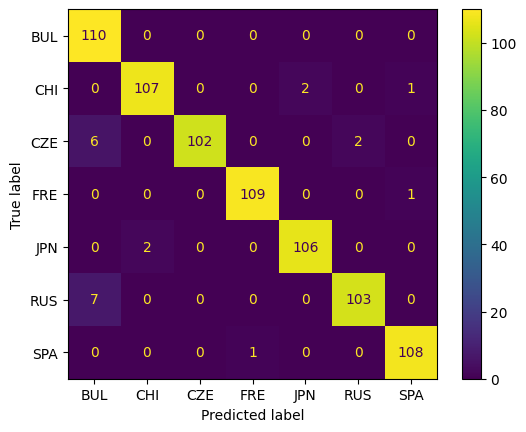

In [ ]:
for count in range(1:3):
  accuracies=[]
  all_predictions = []
  all_test_index = []
  for model_index, (train_index, test_index) in enumerate(skf.split(x, y)):
    model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = f"/content/drive/MyDrive/thesis_NLI/ICLE/finetuned_gemma/finetuned_gemma_7b_1_{model_index}",
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
    )
    x_test_fold, y_test_fold = np.array(x)[test_index], np.array(y)[test_index]

    eos_token = 'Response:'
    results_ICLE = "/content/drive/MyDrive/thesis_NLI/ICLE-NLI-results.csv"
    predictions = classify(x_test_fold, y_test_fold, "ICLE", eos_token, results_ICLE, closedopen_setting='closed')
    accuracy = accuracy_score(y_test_fold, predictions)
    accuracy2 = "{:.2f}".format(accuracy*100)

    # print(f'-------------Run: {model_index}')
    # print(f'-------------Accuracy: {accuracy2}')
    accuracy=float(accuracy)
    accuracies.append(accuracy)
    all_test_index.extend(test_index.tolist())
    all_predictions.extend(predictions)

  avg_acc=sum(accuracies)/5
  print(avg_acc*100)
  print(np.std(accuracies))

  print(accuracies)
  results_dict = {}
  from collections import OrderedDict
  for index, pred in zip(all_test_index, all_predictions):
    results_dict[index] = pred
  print(results_dict)
  sorted_dict = OrderedDict(sorted(results_dict.items()))
  sorted_predictions = list(sorted_dict.values())
  icle = "/content/drive/MyDrive/thesis_NLI/ICLE-NLI-results.csv"
  df = pd.read_csv(icle)
  column_name = f'preds_finetuned_gemma_{count}'
  num_columns = len(df.columns)
  df.insert(num_columns, column_name, sorted_predictions)
  df.to_csv(icle, index=False)
  cm = confusion_matrix(y, sorted_predictions, labels=all_labels_ICLE)
  cm_display = ConfusionMatrixDisplay(cm, display_labels=all_labels_ICLE).plot()
  cm_display.figure_.savefig(f'/content/drive/MyDrive/thesis_NLI/{column_name}.png')

In [ ]:
avg_acc=sum(accuracies)/5
print(avg_acc)
print(len(all_predictions))
df = pd.read_csv(icle)
column_name = 'preds_finetuned_gemma_run3'
preds = df[column_name].tolist()
accuracy = accuracy_score(y, preds)
print(accuracy*100)

0.9675324675324675
770
96.75324675324676


In [ ]:
cm_display.figure_.savefig('/content/drive/MyDrive/thesis_NLI/finetuned_icle_run2.png')

In [ ]:
# results_dict = {}
icle = "/content/drive/MyDrive/thesis_NLI/ICLE-NLI-results.csv"
df = pd.read_csv(icle)
column_name = 'preds_finetuned_llama2_7b'
pred = df[column_name].tolist()
# new_predictions=[]
# for x in pred:
#   if x=='other':
#     x ='SPA'
#   new_predictions.append(x)
accuracy = accuracy_score(y, pred)
accuracy = "{:.2f}".format(accuracy*100)
print(accuracy)

# df.pop(column_name)
# num_columns = len(df.columns)
# df.insert(num_columns, column_name, new_predictions)
# df.head()
# df.to_csv(icle, index=False)

In [ ]:
count=0
accuracies=[]
all_test_index=[]
all_predictions=[]
for train_index, test_index in skf.split(x, y):
  x_test_fold, y_test_fold = np.array(x)[test_index], np.array(y)[test_index]
  model, tokenizer = FastLanguageModel.from_pretrained(
  model_name = f"/content/drive/MyDrive/thesis_NLI/ICLE/finetuned_gemma_7b_{count}", # YOUR MODEL YOU USED FOR TRAINING
  max_seq_length = max_seq_length,
  dtype = dtype,
  load_in_4bit = load_in_4bit,
  )
  FastLanguageModel.for_inference(model) # Enable native 2x faster inference
  eos_token = 'Response:'
  results_ICLE = "/content/drive/MyDrive/thesis_NLI/ICLE-NLI-results.csv"
  predictions = classify(x_test_fold, y_test_fold, "ICLE", eos_token, results_ICLE, closedopen_setting='closed')
  count+=1
  accuracy = accuracy_score(y_test_fold, predictions)
  accuracy2 = "{:.2f}".format(accuracy*100)

  print(f'-------------Run: {count}')
  print(f'-------------Accuracy: {accuracy2}')
  accuracy=float(accuracy)
  accuracies.append(accuracy)
  all_test_index.extend(test_index.tolist())
  all_predictions.extend(predictions)

for index, pred in zip(all_test_index, all_predictions):
  results_dict[index] = pred
print(results_dict)
sorted_dict = OrderedDict(sorted(results_dict.items()))
sorted_predictions = list(sorted_dict.values())


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Unused kwargs: ['_load_in_4bit', '_load_in_8bit', 'quant_method']. These kwargs are not used in <class 'transformers.utils.quantization_config.BitsAndBytesConfig'>.
Gemma's activation function should be approximate GeLU and not exact GeLU.
Changing the activation function to `gelu_pytorch_tanh`.if you want to use the legacy `gelu`, edit the `model.config` to set `hidden_activation=gelu`   instead of `hidden_act`. See https://github.com/huggingface/transformers/pull/29402 for more details.


==((====))==  Unsloth: Fast Gemma patching release 2024.5
   \\   /|    GPU: NVIDIA A100-SXM4-40GB. Max memory: 39.564 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.2.1+cu121. CUDA = 8.0. CUDA Toolkit = 12.1.
\        /    Bfloat16 = TRUE. Xformers = 0.0.25.post1. FA = False.
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth


Unsloth 2024.5 patched 28 layers with 28 QKV layers, 28 O layers and 28 MLP layers.


BUL
1 {'native_lang': 'BUL'}
F1 score: 1.00
BUL
2 {'native_lang': 'BUL'}
F1 score: 1.00
BUL
3 {'native_lang': 'BUL'}
F1 score: 1.00
BUL
4 {'native_lang': 'BUL'}
F1 score: 1.00
BUL
5 {'native_lang': 'BUL'}
F1 score: 1.00
BUL
6 {'native_lang': 'BUL'}
F1 score: 1.00
BUL
7 {'native_lang': 'BUL'}
F1 score: 1.00
BUL
8 {'native_lang': 'BUL'}
F1 score: 1.00
BUL
9 {'native_lang': 'BUL'}
F1 score: 1.00
BUL
10 {'native_lang': 'BUL'}
F1 score: 1.00
BUL
11 {'native_lang': 'BUL'}
F1 score: 1.00
BUL
12 {'native_lang': 'BUL'}
F1 score: 1.00
BUL
13 {'native_lang': 'BUL'}
F1 score: 1.00
BUL
14 {'native_lang': 'BUL'}
F1 score: 1.00
BUL
15 {'native_lang': 'BUL'}
F1 score: 1.00
BUL
16 {'native_lang': 'BUL'}
F1 score: 1.00
BUL
17 {'native_lang': 'BUL'}
F1 score: 1.00
BUL
18 {'native_lang': 'BUL'}
F1 score: 1.00
BUL
19 {'native_lang': 'BUL'}
F1 score: 1.00
BUL
20 {'native_lang': 'BUL'}
F1 score: 1.00
BUL
21 {'native_lang': 'BUL'}
F1 score: 1.00
BUL
22 {'native_lang': 'BUL'}
F1 score: 1.00
CHI
23 {'native_lan

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Unused kwargs: ['_load_in_4bit', '_load_in_8bit', 'quant_method']. These kwargs are not used in <class 'transformers.utils.quantization_config.BitsAndBytesConfig'>.


BUL
1 {'native_lang': 'BUL'}
F1 score: 1.00
BUL
2 {'native_lang': 'BUL'}
F1 score: 1.00
BUL
3 {'native_lang': 'BUL'}
F1 score: 1.00
BUL
4 {'native_lang': 'BUL'}
F1 score: 1.00
BUL
5 {'native_lang': 'BUL'}
F1 score: 1.00
BUL
6 {'native_lang': 'BUL'}
F1 score: 1.00
BUL
7 {'native_lang': 'BUL'}
F1 score: 1.00
BUL
8 {'native_lang': 'BUL'}
F1 score: 1.00
BUL
9 {'native_lang': 'BUL'}
F1 score: 1.00
BUL
10 {'native_lang': 'BUL'}
F1 score: 1.00
BUL
11 {'native_lang': 'BUL'}
F1 score: 1.00
BUL
12 {'native_lang': 'BUL'}
F1 score: 1.00
BUL
13 {'native_lang': 'BUL'}
F1 score: 1.00
BUL
14 {'native_lang': 'BUL'}
F1 score: 1.00
BUL
15 {'native_lang': 'BUL'}
F1 score: 1.00
BUL
16 {'native_lang': 'BUL'}
F1 score: 1.00
BUL
17 {'native_lang': 'BUL'}
F1 score: 1.00
BUL
18 {'native_lang': 'BUL'}
F1 score: 1.00
BUL
19 {'native_lang': 'BUL'}
F1 score: 1.00
BUL
20 {'native_lang': 'BUL'}
F1 score: 1.00
BUL
21 {'native_lang': 'BUL'}
F1 score: 1.00
BUL
22 {'native_lang': 'BUL'}
F1 score: 1.00
CHI
23 {'native_lan

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Unused kwargs: ['_load_in_4bit', '_load_in_8bit', 'quant_method']. These kwargs are not used in <class 'transformers.utils.quantization_config.BitsAndBytesConfig'>.


SPA
154 {'native_lang': 'SPA'}
F1 score: 0.97
-------------Run: 2
-------------Accuracy: 97.40
==((====))==  Unsloth: Fast Gemma patching release 2024.5
   \\   /|    GPU: NVIDIA A100-SXM4-40GB. Max memory: 39.564 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.2.1+cu121. CUDA = 8.0. CUDA Toolkit = 12.1.
\        /    Bfloat16 = TRUE. Xformers = 0.0.25.post1. FA = False.
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
BUL
1 {'native_lang': 'BUL'}
F1 score: 1.00
BUL
2 {'native_lang': 'BUL'}
F1 score: 1.00
BUL
3 {'native_lang': 'BUL'}
F1 score: 1.00
BUL
4 {'native_lang': 'BUL'}
F1 score: 1.00
BUL
5 {'native_lang': 'BUL'}
F1 score: 1.00
BUL
6 {'native_lang': 'BUL'}
F1 score: 1.00
BUL
7 {'native_lang': 'BUL'}
F1 score: 1.00
BUL
8 {'native_lang': 'BUL'}
F1 score: 1.00
BUL
9 {'native_lang': 'BUL'}
F1 score: 1.00
BUL
10 {'native_lang': 'BUL'}
F1 score: 1.00
BUL
11 {'native_lang': 'BUL'}
F1 score: 1.00
BUL
12 {'native_lang': 'BUL'}
F1 score: 1.00
BUL
13 {'native_lang': 'B

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Unused kwargs: ['_load_in_4bit', '_load_in_8bit', 'quant_method']. These kwargs are not used in <class 'transformers.utils.quantization_config.BitsAndBytesConfig'>.


SPA
154 {'native_lang': 'SPA'}
F1 score: 0.98
-------------Run: 3
-------------Accuracy: 98.05
==((====))==  Unsloth: Fast Gemma patching release 2024.5
   \\   /|    GPU: NVIDIA A100-SXM4-40GB. Max memory: 39.564 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.2.1+cu121. CUDA = 8.0. CUDA Toolkit = 12.1.
\        /    Bfloat16 = TRUE. Xformers = 0.0.25.post1. FA = False.
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
BUL
1 {'native_lang': 'BUL'}
F1 score: 1.00
BUL
2 {'native_lang': 'BUL'}
F1 score: 1.00
BUL
3 {'native_lang': 'BUL'}
F1 score: 1.00
BUL
4 {'native_lang': 'BUL'}
F1 score: 1.00
BUL
5 {'native_lang': 'BUL'}
F1 score: 1.00
BUL
6 {'native_lang': 'BUL'}
F1 score: 1.00
BUL
7 {'native_lang': 'BUL'}
F1 score: 1.00
BUL
8 {'native_lang': 'BUL'}
F1 score: 1.00
BUL
9 {'native_lang': 'BUL'}
F1 score: 1.00
BUL
10 {'native_lang': 'BUL'}
F1 score: 1.00
BUL
11 {'native_lang': 'BUL'}
F1 score: 1.00
BUL
12 {'native_lang': 'BUL'}
F1 score: 1.00
BUL
13 {'native_lang': 'B

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Unused kwargs: ['_load_in_4bit', '_load_in_8bit', 'quant_method']. These kwargs are not used in <class 'transformers.utils.quantization_config.BitsAndBytesConfig'>.


SPA
154 {'native_lang': 'SPA'}
F1 score: 0.80
-------------Run: 4
-------------Accuracy: 91.56
==((====))==  Unsloth: Fast Gemma patching release 2024.5
   \\   /|    GPU: NVIDIA A100-SXM4-40GB. Max memory: 39.564 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.2.1+cu121. CUDA = 8.0. CUDA Toolkit = 12.1.
\        /    Bfloat16 = TRUE. Xformers = 0.0.25.post1. FA = False.
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
BUL
1 {'native_lang': 'BUL'}
F1 score: 1.00
BUL
2 {'native_lang': 'BUL'}
F1 score: 1.00
BUL
3 {'native_lang': 'BUL'}
F1 score: 1.00
BUL
4 {'native_lang': 'BUL'}
F1 score: 1.00
BUL
5 {'native_lang': 'BUL'}
F1 score: 1.00
BUL
6 {'native_lang': 'BUL'}
F1 score: 1.00
BUL
7 {'native_lang': 'BUL'}
F1 score: 1.00
BUL
8 {'native_lang': 'BUL'}
F1 score: 1.00
BUL
9 {'native_lang': 'BUL'}
F1 score: 1.00
BUL
10 {'native_lang': 'BUL'}
F1 score: 1.00
BUL
11 {'native_lang': 'BUL'}
F1 score: 1.00
BUL
12 {'native_lang': 'BUL'}
F1 score: 1.00
BUL
13 {'native_lang': 'B

,filename,text,language,preds_zero_llama7b,preds_zero_llama3_temp0,preds_zero_flant5_xxl,preds_zero_flant5_xxl_openclass,preds_zero_llama3_openclass,preds_zero_llama2_7b_openclass,preds_zero_gemma_7b,preds_zero_gemma_7b_openclass,preds_finetuned_llama2_7b,preds_finetuned_llama3_8b,preds_finetuned_mistral_7b,preds_finetuned_gemma_7b
0,BGSU1001,"It is time , that our society is dominated by ...",BUL,RUS,FRE,CZE,RUS,GER,ENG,FRE,ENG,RUS,BUL,BUL,BUL
1,BGSU1003,Once upon a time there lived a beautiful young...,BUL,BUL,RUS,CZE,RUS,RUS,ENG,FRE,ENG,BUL,BUL,BUL,BUL
2,BGSU1004,Our educational system in one of the largest i...,BUL,CHI,SPA,CHI,ENG,ENG,ENG,FRE,ENG,BUL,BUL,BUL,BUL
3,BGSU1006,"As stated , the topic is based on the assumpti...",BUL,BUL,BUL,BUL,ENG,ENG,other,BUL,BUL,RUS,BUL,RUS,BUL
4,BGSU1007,"Hard , as our modern times are , they make as ...",BUL,CHI,FRE,CZE,RUS,RUS,ENG,FRE,ENG,RUS,BUL,RUS,BUL


In [ ]:
new_predictions = []
for s in sorted_predictions:
  if s=='other':
    s='SPA'
  new_predictions.append(s)
icle = "/content/drive/MyDrive/thesis_NLI/ICLE-NLI-results.csv"
df = pd.read_csv(icle)
num_columns = len(df.columns)
column_name = 'preds_finetuned_gemma_7b'
df.insert(num_columns, column_name, new_predictions)
accuracy = accuracy_score(y, new_predictions)
accuracy = "{:.2f}".format(accuracy*100)
print(accuracy)
df.head()
df.to_csv(icle)

96.75


In [ ]:
results_dict = {}
from collections import OrderedDict
# all_test_index2 = []
# for xs in all_test_index:
#     for x in xs:
#         all_test_index2.append(x)
# all_predictions2 = []
# for xs in all_predictions:
#     for x in xs:
#         all_predictions2.append(x)

for index, pred in zip(all_test_index, all_predictions):
  results_dict[index] = pred
print(results_dict)
sorted_dict = OrderedDict(sorted(results_dict.items()))
sorted_predictions = list(sorted_dict.values())
icle = "/content/drive/MyDrive/thesis_NLI/ICLE-NLI-results.csv"
df = pd.read_csv(icle)
num_columns = len(df.columns)
column_name = 'preds_finetuned_gemma_7b'
df.insert(num_columns, column_name, sorted_predictions)
df.head()
df.to_csv(icle, index=False)


{12: 'BUL', 21: 'BUL', 33: 'CZE', 36: 'BUL', 53: 'BUL', 55: 'BUL', 69: 'BUL', 70: 'BUL', 74: 'BUL', 76: 'RUS', 82: 'BUL', 84: 'BUL', 87: 'BUL', 90: 'BUL', 92: 'BUL', 93: 'BUL', 96: 'BUL', 99: 'BUL', 100: 'BUL', 103: 'BUL', 105: 'BUL', 107: 'BUL', 118: 'CHI', 131: 'CHI', 133: 'CHI', 138: 'CHI', 141: 'CHI', 143: 'CHI', 145: 'CHI', 148: 'CZE', 150: 'CHI', 164: 'JPN', 169: 'CHI', 174: 'CHI', 176: 'CHI', 187: 'CHI', 188: 'CHI', 189: 'CHI', 198: 'CHI', 203: 'CHI', 205: 'CHI', 212: 'CHI', 213: 'CHI', 219: 'CHI', 224: 'CZE', 240: 'RUS', 241: 'BUL', 244: 'CZE', 245: 'CZE', 247: 'CZE', 254: 'CZE', 259: 'CZE', 262: 'CZE', 265: 'CZE', 268: 'CZE', 270: 'CZE', 271: 'CZE', 273: 'CZE', 274: 'CZE', 279: 'CZE', 281: 'CZE', 284: 'CZE', 303: 'JPN', 312: 'CZE', 319: 'CZE', 328: 'CZE', 330: 'FRE', 331: 'FRE', 332: 'FRE', 334: 'FRE', 336: 'FRE', 338: 'FRE', 339: 'FRE', 343: 'FRE', 344: 'BUL', 345: 'FRE', 352: 'FRE', 358: 'CZE', 370: 'FRE', 378: 'FRE', 380: 'FRE', 391: 'FRE', 401: 'FRE', 412: 'FRE', 419: 'FRE

In [ ]:
df.head()

,filename,text,language,preds_zero_llama7b,preds_zero_llama3_temp0,preds_zero_flant5_xxl,preds_zero_flant5_xxl_openclass,preds_zero_llama3_openclass,preds_zero_llama2_7b_openclass,preds_zero_gemma_7b,preds_zero_gemma_7b_openclass,preds_finetuned_llama2_7b,preds_finetuned_llama3_8b
0,BGSU1001,"It is time , that our society is dominated by ...",BUL,RUS,FRE,CZE,RUS,GER,ENG,FRE,ENG,RUS,BUL
1,BGSU1003,Once upon a time there lived a beautiful young...,BUL,BUL,RUS,CZE,RUS,RUS,ENG,FRE,ENG,BUL,BUL
2,BGSU1004,Our educational system in one of the largest i...,BUL,CHI,SPA,CHI,ENG,ENG,ENG,FRE,ENG,BUL,BUL
3,BGSU1006,"As stated , the topic is based on the assumpti...",BUL,BUL,BUL,BUL,ENG,ENG,other,BUL,BUL,RUS,BUL
4,BGSU1007,"Hard , as our modern times are , they make as ...",BUL,CHI,FRE,CZE,RUS,RUS,ENG,FRE,ENG,RUS,BUL


In [ ]:
for col in df.columns:
  if "Unnamed" in col:
    df = df.drop(col, axis=1)
for col in df.columns:
  print(col)
df.to_csv(icle, index=False)

filename
text
language
preds_zero_llama7b
preds_zero_llama3_temp0
preds_zero_flant5_xxl
preds_zero_flant5_xxl_openclass
preds_zero_llama3_openclass
preds_zero_llama2_7b_openclass
preds_zero_gemma_7b
preds_zero_gemma_7b_openclass
preds_finetuned_llama2_7b


In [ ]:
# llama 3 8b
acc = []
for a in accuracies:
  a = float(a)
  acc.append(a)

avg_acc=sum(acc)/5
print(avg_acc)

print(accuracies)

78.83000000000001
['80.52', '86.36', '79.87', '66.23', '81.17']


<a name="Train"></a>
### Train the model
Now let's use Huggingface TRL's `SFTTrainer`! More docs here: [TRL SFT docs](https://huggingface.co/docs/trl/sft_trainer). We do 60 steps to speed things up, but you can set `num_train_epochs=1` for a full run, and turn off `max_steps=None`. We also support TRL's `DPOTrainer`!

In [ ]:
from trl import SFTTrainer
from transformers import TrainingArguments

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = dataset,
    dataset_text_field = "text",
    max_seq_length = max_seq_length,
    dataset_num_proc = 2,
    packing = False, # Can make training 5x faster for short sequences.
    args = TrainingArguments(
        per_device_train_batch_size = 4, # The batch size per GPU/TPU core/CPU for training. Zhang et al set this to 4
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        #max_steps = 0,
        num_train_epochs=3,
        learning_rate = 1e-4, # originally 2e-4
        fp16 = not torch.cuda.is_bf16_supported(),
        bf16 = torch.cuda.is_bf16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
    ),
)



/usr/local/lib/python3.10/dist-packages/multiprocess/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Map (num_proc=2):   0%|          | 0/11000 [00:00<?, ? examples/s]

In [ ]:
#@title Show current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = NVIDIA A100-SXM4-40GB. Max memory = 39.564 GB.
4.5 GB of memory reserved.


In [ ]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 11,000 | Num Epochs = 3
O^O/ \_/ \    Batch size per device = 4 | Gradient Accumulation steps = 4
\        /    Total batch size = 16 | Total steps = 2,061
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss
1,2.142800
2,2.093000
3,2.092200
4,2.028900
5,1.977500
6,1.965000
7,1.949900
8,1.709100
9,1.697700
10,1.562700


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in

In [ ]:
#@title Show final memory and time stats
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory         /max_memory*100, 3)
lora_percentage = round(used_memory_for_lora/max_memory*100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training.")
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

NameError: name 'start_gpu_memory' is not defined

<a name="Save"></a>
### Saving, loading finetuned models
To save the final model as LoRA adapters, either use Huggingface's `push_to_hub` for an online save or `save_pretrained` for a local save.

**[NOTE]** This ONLY saves the LoRA adapters, and not the full model. To save to 16bit or GGUF, scroll down!

In [ ]:
model.save_pretrained("/content/drive/MyDrive/thesis_NLI/TOEFL11/finetuned_mistral_7b") # Local saving
tokenizer.save_pretrained("/content/drive/MyDrive/thesis_NLI/TOEFL11/finetuned_mistral_7b")
# model.push_to_hub("your_name/lora_model", token = "...") # Online saving
# tokenizer.push_to_hub("your_name/lora_model", token = "...") # Online saving

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


('/content/drive/MyDrive/thesis_NLI/TOEFL11/finetuned_mistral_7b/tokenizer_config.json',
 '/content/drive/MyDrive/thesis_NLI/TOEFL11/finetuned_mistral_7b/special_tokens_map.json',
 '/content/drive/MyDrive/thesis_NLI/TOEFL11/finetuned_mistral_7b/tokenizer.model',
 '/content/drive/MyDrive/thesis_NLI/TOEFL11/finetuned_mistral_7b/added_tokens.json',
 '/content/drive/MyDrive/thesis_NLI/TOEFL11/finetuned_mistral_7b/tokenizer.json')

Now if you want to load the LoRA adapters we just saved for inference, set `False` to `True`:

In [ ]:
if False:
    from unsloth import FastLanguageModel
    model, tokenizer = FastLanguageModel.from_pretrained(
        model_name = "finetuned_llama3_8b", # YOUR MODEL YOU USED FOR TRAINING
        max_seq_length = max_seq_length,
        dtype = dtype,
        load_in_4bit = load_in_4bit,
    )
    FastLanguageModel.for_inference(model) # Enable native 2x faster inference

# alpaca_prompt = You MUST copy from above!

inputs = tokenizer(
[
    alpaca_prompt.format(
        "What is a famous tall tower in Paris?", # instruction
        "", # input
        "", # output - leave this blank for generation!
    )
], return_tensors = "pt").to("cuda")

outputs = model.generate(**inputs, max_new_tokens = 64, use_cache = True)
tokenizer.batch_decode(outputs)

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


["<|begin_of_text|>Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.\n\n### Instruction:\nWhat is a famous tall tower in Paris?\n\n### Input:\n\n\n### Response:\nThe Eiffel Tower is a famous tall tower in Paris, France. It is 324 meters (1,063 feet) tall and was built in 1889 for the World's Fair. It is the most visited paid monument in the world, with over 7 million visitors annually. The tower is named after"]

You can also use Hugging Face's `AutoModelForPeftCausalLM`. Only use this if you do not have `unsloth` installed. It can be hopelessly slow, since `4bit` model downloading is not supported, and Unsloth's **inference is 2x faster**.

In [ ]:
if False:
    # I highly do NOT suggest - use Unsloth if possible
    from peft import AutoPeftModelForCausalLM
    from transformers import AutoTokenizer
    model = AutoPeftModelForCausalLM.from_pretrained(
        "lora_model", # YOUR MODEL YOU USED FOR TRAINING
        load_in_4bit = load_in_4bit,
    )
    tokenizer = AutoTokenizer.from_pretrained("lora_model")

### Saving to float16 for VLLM

We also support saving to `float16` directly. Select `merged_16bit` for float16 or `merged_4bit` for int4. We also allow `lora` adapters as a fallback. Use `push_to_hub_merged` to upload to your Hugging Face account! You can go to https://huggingface.co/settings/tokens for your personal tokens.

In [ ]:
# Merge to 16bit
if False: model.save_pretrained_merged("model", tokenizer, save_method = "merged_16bit",)
if False: model.push_to_hub_merged("hf/model", tokenizer, save_method = "merged_16bit", token = "")

# Merge to 4bit
if False: model.save_pretrained_merged("model", tokenizer, save_method = "merged_4bit",)
if False: model.push_to_hub_merged("hf/model", tokenizer, save_method = "merged_4bit", token = "")

# Just LoRA adapters
if False: model.save_pretrained_merged("model", tokenizer, save_method = "lora",)
if False: model.push_to_hub_merged("hf/model", tokenizer, save_method = "lora", token = "")

### GGUF / llama.cpp Conversion
To save to `GGUF` / `llama.cpp`, we support it natively now! We clone `llama.cpp` and we default save it to `q8_0`. We allow all methods like `q4_k_m`. Use `save_pretrained_gguf` for local saving and `push_to_hub_gguf` for uploading to HF.

Some supported quant methods (full list on our [Wiki page](https://github.com/unslothai/unsloth/wiki#gguf-quantization-options)):
* `q8_0` - Fast conversion. High resource use, but generally acceptable.
* `q4_k_m` - Recommended. Uses Q6_K for half of the attention.wv and feed_forward.w2 tensors, else Q4_K.
* `q5_k_m` - Recommended. Uses Q6_K for half of the attention.wv and feed_forward.w2 tensors, else Q5_K.

In [ ]:
# Save to 8bit Q8_0
if False: model.save_pretrained_gguf("model", tokenizer,)
if False: model.push_to_hub_gguf("hf/model", tokenizer, token = "")

# Save to 16bit GGUF
if False: model.save_pretrained_gguf("model", tokenizer, quantization_method = "f16")
if False: model.push_to_hub_gguf("hf/model", tokenizer, quantization_method = "f16", token = "")

# Save to q4_k_m GGUF
if False: model.save_pretrained_gguf("model", tokenizer, quantization_method = "q4_k_m")
if False: model.push_to_hub_gguf("hf/model", tokenizer, quantization_method = "q4_k_m", token = "")

Now, use the `model-unsloth.gguf` file or `model-unsloth-Q4_K_M.gguf` file in `llama.cpp` or a UI based system like `GPT4All`. You can install GPT4All by going [here](https://gpt4all.io/index.html).

And we're done! If you have any questions on Unsloth, we have a [Discord](https://discord.gg/u54VK8m8tk) channel! If you find any bugs or want to keep updated with the latest LLM stuff, or need help, join projects etc, feel free to join our Discord!

Some other links:
1. Zephyr DPO 2x faster [free Colab](https://colab.research.google.com/drive/15vttTpzzVXv_tJwEk-hIcQ0S9FcEWvwP?usp=sharing)
2. Llama 7b 2x faster [free Colab](https://colab.research.google.com/drive/1lBzz5KeZJKXjvivbYvmGarix9Ao6Wxe5?usp=sharing)
3. TinyLlama 4x faster full Alpaca 52K in 1 hour [free Colab](https://colab.research.google.com/drive/1AZghoNBQaMDgWJpi4RbffGM1h6raLUj9?usp=sharing)
4. CodeLlama 34b 2x faster [A100 on Colab](https://colab.research.google.com/drive/1y7A0AxE3y8gdj4AVkl2aZX47Xu3P1wJT?usp=sharing)
5. Mistral 7b [free Kaggle version](https://www.kaggle.com/code/danielhanchen/kaggle-mistral-7b-unsloth-notebook)
6. We also did a [blog](https://huggingface.co/blog/unsloth-trl) with 🤗 HuggingFace, and we're in the TRL [docs](https://huggingface.co/docs/trl/main/en/sft_trainer#accelerate-fine-tuning-2x-using-unsloth)!
7. `ChatML` for ShareGPT datasets, [conversational notebook](https://colab.research.google.com/drive/1Aau3lgPzeZKQ-98h69CCu1UJcvIBLmy2?usp=sharing)
8. Text completions like novel writing [notebook](https://colab.research.google.com/drive/1ef-tab5bhkvWmBOObepl1WgJvfvSzn5Q?usp=sharing)

<div class="align-center">
  <a href="https://github.com/unslothai/unsloth"><img src="https://github.com/unslothai/unsloth/raw/main/images/unsloth%20new%20logo.png" width="115"></a>
  <a href="https://discord.gg/u54VK8m8tk"><img src="https://github.com/unslothai/unsloth/raw/main/images/Discord.png" width="145"></a>
  <a href="https://ko-fi.com/unsloth"><img src="https://github.com/unslothai/unsloth/raw/main/images/Kofi button.png" width="145"></a></a> Support our work if you can! Thanks!
</div>